# Estimation des pluies en Guyane

Ce framework a pour objectif d'évaluer différentes estimation de la pluviométrie en Guyane
Les sources des données utilisées sont :
- vérité terrain MétéoFrance
- images de température de brillance SSMIS produit par la NSIDC (API_NSIDC)
- images de température de surface SEVIRI produit par meteosat (API_METEOSAT)
- estimation IMERG produit par la NASA et JAXA (API_IMERG)
  
Les changements principaux à effectuer dans le code sont marqués par le mot clé TODO, dans la deuxième partie de code

## imports

In [2]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d, Rbf
from scipy.optimize import curve_fit
import random
import pandas as pd
import json
import sys
import os

# modules du répertoire courant
from classification import classification
import ground_truth_rain as gt

# modules du répertoire Images
sys.path.insert(0, r'../Images')
from Image import Image,compute_var
from File import File
from Geotiff_Format import Geotiff_Format

# modules du répertoire tools
sys.path.insert(0, r'../tools')
from tools import get_index,save_index,make_directory

# modules des répertoires des API 
sys.path.insert(0, r'API_METEOSAT')
from meteosat_download import download_SEVIRI_image
sys.path.insert(0, r'API_NSIDC')
from SSMIS_download import download_SSMIS_image
sys.path.insert(0, r'API_IMERG')
from IMERG_download import download_IMERG_image

## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [3]:

##### variables principales     #################################################################

# TODO : chemin d'accès au dossier principal où les fichiers seront générés
main_dir = make_directory(r"../../data/estimation_rain")

# TODO : chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : chemin d'accès au fichier csv contenant la vérité terrain
gt_fn = r"../../data/pluie_sol/gauges_guyane_1h_utc.csv"

##### gestion de l'index        #################################################################

# l'index est un fichier json ou dictionnaire contenant pour chaque date les images correspondantes
# il est utile pour télécharger et combiner les images d'une même date

# TODO : remplir le chemin d'accès au fichier json index
index_path = main_dir + r"/acq_dates.json"

# TODO : Pour compléter les dates visées dans le format suivant
target_dates = [
    "2020-05-03T12:00:00.000000+0000",
    "2020-05-08T12:00:00.000000+0000",
    "2020-05-15T12:00:00.000000+0000",
    "2020-05-18T12:00:00.000000+0000",
    "2020-05-26T12:00:00.000000+0000",
    "2020-12-12T12:00:00.000000+0000",
    "2020-12-29T12:00:00.000000+0000"
]

# TODO : si l'index est utile à l'utilisation et qu'il n'est pas déjà mis en place,
# décommenter les 2 lignes ci-dessous pour l'initialiser

#index = {d.split(" ")[0]:{"target":d} for d in target_dates} # initialisation des clés de l'index
#save_index(index,index_path)   

##### clés de téléchargement        #################################################################

# TODO : pour le téléchargement des images
# remplir le chemin d'accès aux fichiers contenant les clés des API
path_API_meteosat_keys = r"../../data/keys/eds.key"         # deux lignes : voir meteosat pour les clés d'accès
path_API_nsidc_keys = r"../../data/keys/mdp_NSIDC.json"     # {"username": "<username>","password": "<password>}"

# TODO : vérifier si besoin les variables suivantes
##### initialisation des variables  #################################################################

# chemin d'accès aux métadatas de la vérité terrain
gt_mtd_fn = os.path.dirname(gt_fn) + r"/gauges_guyane_metadata.csv"

# chemins d'accès aux dossiers où seront téléchargés les fichiers bruts 
# la taille de ces fichiers peut devenir assez importante, notamment pour les images SEVIRI
SSMIS_src_dir = make_directory(r"../../data/SSMIS/download")
SEVIRI_src_dir = make_directory(r"../../data/SEVIRI/download")
IMERG_src_dir = make_directory(r"../../data/IMERG/download")

# chemins d'accès aux dossiers où seront téléchargés les fichiers reprojetés
SSMIS_proj_dir  = make_directory(main_dir + r"/SSMIS")
SEVIRI_proj_dir = make_directory(main_dir + r"/SEVIRI")
rr_dir          = make_directory(main_dir + r"/rain_rate")
agr_dir         = make_directory(main_dir + r"/agregation")
seg_dir         = make_directory(main_dir + r"/classification")
eval_dir        = make_directory(main_dir+r"/evaluation")

# chargement de la projection
projection = json.load(open(projection_path, "r", encoding="utf-8")) 

# format principal des dates
format = "%Y-%m-%dT%H:%M:%S.%f%z"

# permet de rechercher les images SSMIS par itération sur différents paramètres
SSMIS_parameters = { 
        "freq":     ["91V",         "91V",          "91V",          "91V"       ],
        "passage":  ["E",           "A",            "E",            "A"         ],
        "capteur":  ["F17_SSMIS",   "F17_SSMIS",    "F16_SSMIS",    "F16_SSMIS" ],
        "algo":     ["GRD",         "GRD",          "GRD",          "GRD"       ],
        "grid":     ["N25km",       "N25km",        "N25km",        "N25km"     ]
        }

## Téléchargement des images par l'index

L'index est un dictionnaire permettant d'accéder les chemins vers les différentes images par date, ce module permet de télécharger certaines images à partir des dates données dans l'index et de mettre celui-ci à jour

### Pour les images SSMIS

In [3]:
def download_SSMIS(attribute):
    """
    Télécharge les données SSMIS, puis réalise leur extraction et leur projection
    Les dates choisies sont les clés de l'index (variable globale index_path)
    Un fichier déjà présent dans le dossier SSMIS_src_dir n'est pas téléchargé à nouveau
    La recherche se fait par itérations sur certains paramètres (variable globale SSMIS_parameters) 
    L'index est automatiquement mis à jour
    
    Args:
        attribute (string) : attribut à extraire de l'image
    """
    index = get_index(index_path)
    for d in index.keys(): # pour chaque date dans le
        # téléchargement des données
        tg_date = datetime.strptime(d,format)
        retour = download_SSMIS_image(tg_date,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys)
        tg_freq = SSMIS_parameters["freq"][0]
        if retour: # un fichier a bien été téléchargé
            src_filename,start_date,end_date = retour
            file = File(src_filename) ; string_d = d[:10]
            tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{tg_freq}_{string_d}.tiff"
            file.project(projection,attribute,out_path=tif_filename) # projection
            # inscription des chemins d'accès à l'index
            index[d][f"SSMIS_src_{tg_freq}"] = src_filename
            index[d][f"start_date_{tg_freq}"] = datetime.strftime(start_date,format)
            index[d][f"end_date_{tg_freq}"] = datetime.strftime(end_date,format)
            index[d][f"SSMIS_tif_{tg_freq}"] = tif_filename
            save_index(index,index_path)
        else:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
        

### Pour les images SEVIRI

In [35]:
def download_SEVIRI(attribute):
    """
    Télécharge les données SEVIRI, puis réalise leur extraction et leur projection
    Un fichier déjà présent dans le dossier SEVIRI_src_dir n'est pas téléchargé à nouveau
    L'index est automatiquement mis à jour
    
    Args:
        attribute (string) : attribut à extraire de l'image
        SEVIRI_parameters (dict) : dictionnaire contenant les paramètres successifs à prendre en compte dans le téléchargement
    """
    nb_files_per_period = 12
    index = get_index(index_path)
    arrays_SEVIRI = []
    for d in index.keys():
        index[d]["IR_SEVIRI_source_files"] = []
        print(f"recherche pour la date {d}")
        start_acq_date = datetime.strptime(index[d]["start_date_91V"],format)
        end_acq_date = datetime.strptime(index[d]["end_date_91V"],format)
        delta = timedelta(seconds=(end_acq_date - start_acq_date).total_seconds() / nb_files_per_period)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        for res_d in researched_dates:
            # téléchargement des données
            retour = download_SEVIRI_image(res_d,SEVIRI_src_dir,path_API_meteosat_keys)
            if retour: # un fichier a bien été téléchargé
                src_filename,start_date,end_date = retour
                index[d]["IR_SEVIRI_source_files"] = index[d]["IR_SEVIRI_source_files"] + [src_filename]
                SEVIRI_file = File(src_filename)
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI.append(img_proj.array)
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI),axis=0),img_proj.lons,img_proj.lats)
        string_d = d[:10]
        tif_filename = SEVIRI_proj_dir + rf"/SEVIRI_TB_{attribute}_{string_d}.tiff"
        img_proj_agreg.save(projection,tif_filename)
        index[d][f"SEVIRI_tif_{attribute}"] = tif_filename
        save_index(index,index_path)

### mise en place

In [ ]:
#download_SEVIRI("IR_108")
#download_SSMIS("TB")

## Agrégation des images par l'index

Il est alors possible d'agréger les images conservées dans l'index

In [36]:
def agregation_geotiff(out_dir,key,mode="mean"):
    """
    premet d'agréger les images correspondantes à toutes les dates contenues dans l'index 

    Args:
        out_dir (string) : chemin vers le répertoire de sortie
        key (string) : clé de l'image à agréger
        mode ("mean" ou "sum") : mode d'agrégation (Default "mean")

    Return:
        img_output (Image) : Image agrégée
    """
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    return img_output


In [98]:
# test unitaire

for key in ["SSMIS_tif_91V","SEVIRI_tif_IR_087"]:
    img_agreg = agregation_geotiff(agr_dir,key)
img_var_IR = img_agreg.computeVar()
img_var_IR.save(projection,agr_dir + rf"/{key}_agreg_var.tiff")

## Relation images - vérité terrain

Ce module permet de mettre en relation une image ou plusieurs avec la vérité terrain.

C'est à dire d'extraire les valeurs des capteurs sur le pixel correspondant

In [4]:
def combine_gt_pixel_from_image(image,start_date,end_date,cols=False):
    """
    Pour une image et pour les capteurs séléctionnés
    associe la valeur du pixel correspondant à la localisation du capteur 
    et renvoie les listes contenant ces valeurs

    Args:
        image (Image) : image dont on veut extraire les données
        start_date (datetime) : date correspondant au début de l'acquisition de l'image
        end_date (datetime) : date correspondant à la fin de l'acquisition de l'image
        cols (bool, list) : liste des index des stations à prendre en compte, les considère toutes si False (Default False)
    
    Return:
        true_rain_sample (list) : liste contenant la vérité terrain
        pixel_values_sample (list) : liste contenant les valeurs des pixels associés
    """
    true_rain_sample, pixel_values_sample = [],[]

    # récupération de la vérité terrain et agrégation
    gt_1h_df = pd.read_csv(gt_fn)
    mtd_df = pd.read_csv(gt_mtd_fn)
    gt_1h_extr_df = gt.extract(gt_1h_df,start_date,end_date)
    
    if isinstance(gt_1h_extr_df, pd.DataFrame):
        gt_agreg_df = gt_1h_extr_df.mean()
    else:
        gt_agreg_df = gt_1h_extr_df

    # mise en place des colones à parcourir
    if cols == False:
        cols = gt_1h_df.columns[1:]
    elif type(cols[0]) == int:
        cols = [gt_1h_df.columns[col_idx] for col_idx in cols]

    # pour chaque station on associe la valeur du pixel à l'agrégation des mesures sur la période d'acquisition
    for col in cols: 
        lat = mtd_df.loc[mtd_df["Numéro"]==int(col)]["lat"].array[0]
        lon = mtd_df.loc[mtd_df["Numéro"]==int(col)]["lon"].array[0]
        lats, lons = image.lats.T[0], image.lons[0]
        idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
        pixel_value = image.array[idx_lat][idx_lon] ; true_rain_value = gt_agreg_df.loc[col]
        if (not np.isnan(true_rain_value)) and (not np.isnan(pixel_value)):
            # vérification que l'une des valeur n'est pas nulle (manque de donnée par exemple)
            true_rain_sample.append(true_rain_value)
            pixel_values_sample.append(pixel_value)
        else:
            print(f"valeur nulle rencontrée : gt = {true_rain_value} ; pixel = {pixel_value}")
    return (true_rain_sample,pixel_values_sample)


def combine_gt_pixel_from_index(key,attribute=1,sdk="start_date",edk="start_date"):
    """
    Pour une certaine image de chaque date de l'index, et pour les capteurs séléctionnés
    associe la valeur du pixel correspondant à la localisation du capteur 
    et renvoie les listes contenant ces valeurs

    Args:
        key (string) : clé correspondant à l'image dont on veut extraire les données
        attribute (int or string) : attribut de l'image à extraire (Default 1)
        sdk (string) : start date key, correspond à la clé indiquant le début de la période d'acquisition de l'Image
        edk (string) : end date key, correspond à la clé indiquant la fin de la période d'acquisition de l'Image
    
    Return:
        true_rain_sample (list) : liste contenant la vérité terrain
        pixel_values_sample (list) : liste contenant les valeurs des pixels associés
    """
    index = get_index(index_path)
    true_rain_sample,pixel_values_sample = [],[]
    for d in index.keys():
        try:
            file = File(index[d][key])
            img = file.project(projection,attribute)
            start_date = datetime.strptime(index[d][sdk],format)
            end_date = datetime.strptime(index[d][edk],format)
            tr_smpl,pv_smpl = combine_gt_pixel_from_image(img,start_date,end_date)
            true_rain_sample.extend(tr_smpl) ; pixel_values_sample.extend(pv_smpl)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    return true_rain_sample,pixel_values_sample

In [ ]:
# test unitaire

netcdf_path = r"..\..\data\IMERG\3B-DAY.MS.MRG.3IMERG.20200503-S000000-E235959.V06.nc4.nc4"
image = File(netcdf_path).project(projection,"HQprecipitation")
std,etd = datetime(2017,5,1,tzinfo=timezone.utc),datetime(2017,5,2,tzinfo=timezone.utc)

combine_gt_pixel_from_image(image,std,etd)

## Méthode RACC à partir de l'index

### à partir des images SSMIS seulement

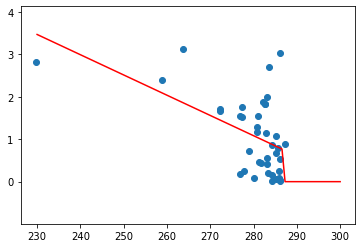

In [7]:
def f_model_MO(array,*args):
    if len(args)==1:
        params = args[0]
        [x_lim,a,b] = params
    elif len(args)==3:
        x_lim,a,b = args
    return np.where(array>x_lim,0,a*array+b)

def fit_model_MO(key,period_keys,plot=True):
    (sdk,edk) = period_keys
    rain_gt,val_images,locations = combine_gt_pixel_from_index(key,sdk=sdk,edk=edk)
    xdata,ydata = [],[]
    for i in range(len(rain_gt)):
        if (not np.isnan(val_images[i])) and (not np.isnan(rain_gt[i])) :
            xdata.append(val_images[i]) ; ydata.append(rain_gt[i])
    xlim = np.max(xdata)
    a = (xdata[0]-xdata[1])/(ydata[0]-ydata[1])
    b = ydata[0] - a*xdata[0]
    param_opt, pcov = curve_fit(f=f_model_MO,xdata=xdata,ydata=ydata,p0=(xlim,a,b))
    if plot:
        xsample = np.linspace(230, 300, 100)
        ysample = [f_model_MO(xsample[i],param_opt) for i in range(len(xsample))]

        plt.plot(xsample,ysample,color="red")
        plt.scatter(xdata,ydata)
        plt.ylim(ymin=np.min(ydata)-1,ymax=np.max(ydata)+1)
        plt.show()
    return param_opt

key = "SSMIS_tif_91V" ; period_keys = ("start_date_91V","end_date_91V")
param_opt = fit_model_MO(key,period_keys)

### à partir de la méthode RACC

In [9]:
def fit_model_RACC(N,model_param,agr_dir,seg_dir):
    array_pred,centers,legend = classification(agr_dir,seg_dir,projection,N=N,standardisation=True,epsilon=0.001,T=100,save=False,show=False)
    new_centers = np.zeros(np.shape(centers))
    idx_MO = np.argmax([("SSMIS" in leg) for leg in legend])
    idx_var = np.argmax([("var" in leg) for leg in legend])
    idx_IR = [i for i in range(len(legend)) if i not in [idx_var,idx_MO]][0]
    new_centers[:, 0] = centers[:, idx_IR]
    new_centers[:, 1] = centers[:, idx_var]
    new_centers[:, 2] = f_model_MO(centers.T[idx_MO],model_param)
    centers_fn = seg_dir+"/centers.npy"
    np.save(centers_fn,new_centers)
    return new_centers

def f_model_RACC(array,centers):
    array_var = compute_var(array)
    (nb_rows,nb_cols) = np.shape(array)
    rain_pred = np.zeros((nb_rows,nb_cols))
    for y in range(nb_rows):
        for x in range(nb_cols):
            c = np.argmin(np.sqrt((centers.T[0]-array[y][x])**2+(centers.T[1]-array_var[y][x])**2))
            rain_pred[y][x] = centers[c][2]
    return rain_pred

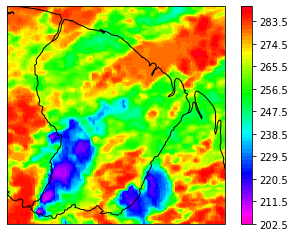

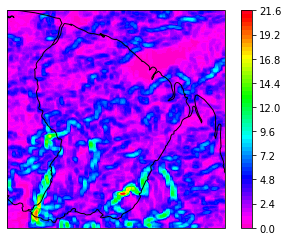

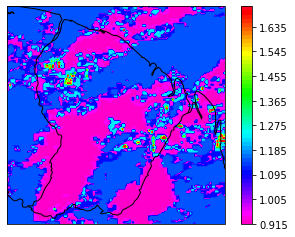

In [10]:
N = 20 ; key="SSMIS_tif_91V" ; 
param_opt = fit_model_MO(key,period_keys,plot=False)
centers = fit_model_RACC(N,param_opt,agr_dir,seg_dir)

fn = r"C:\Users\Baptiste\Documents\ENSG\stage\data\SEVIRI\MSG4-SEVI-MSG15-0100-NA-20211230201243.081000000Z-NA.nat"

image = File(fn).project(projection,"IR_087")
image.show()
var = image.computeVar()
var.show()
arr_result = f_model_RACC(image.array,centers)
rain_estim = Image(arr_result,image.lons,image.lats)
rain_estim.show()

### application du modèle

In [ ]:
def compute_rain_rate(key,f_model,params,out_dir=False,show=True):
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            image = File(index[d][key]).getImage(1)
            R = f_model(image.array,params)
            img_rain_rate = Image(R,image.lons,image.lats)
            if out_dir:
                filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
                img_rain_rate.save(projection,filename)
                index[d]["rain_rate"] = filename
                save_index(index,index_path)
            if show:
                img_rain_rate.show()
        except KeyError:
            print(f"l'un des fichiers correspondant à la date {d} n'a pas été trouvé")

compute_rain_rate("SEVIRI_IR_108_tif",f_model_RACC,centers,rr_dir)

## Comparaison images - vérité terrain

Ce module permet de comparer les images avec la vérité terrain en calculant les métriques associées



In [5]:
def compare_gt_pixel_values(ground_list,estim_list,indice_corr="Pearson",savefig=False):
    """
    Compare une liste d'estimation d'une valeur avec une liste vérité terrain
    Les métriques calcuées sont le coefficient de corrélation, le RMSE et le BIAS

    Args :
        ground_list (list) : liste des valeurs de vérité terrain
        estim_list (list) : liste des valeurs estimée
        indice_corr ("Pearson" ou "Spearman") : type du coefficient de corrélation calculé (Default "Pearson")
        savefig (Bool - string) : si non faux, enregistre la figure avec le chemin savefig

    Return :
        corr (float) : coefficient de corrélation
        RMSE (float) : Root Mean Square Error - moyenne des erreurs quadratiques
        BIAS (float) : biais
    """
    ground_list,estim_list = np.array(ground_list),np.array(estim_list)
    xmin,xmax,attributes = 260,290,False

    if indice_corr == "Pearson":
        corr, _ = pearsonr(ground_list, estim_list)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(ground_list, estim_list)
    RMSE = np.sqrt(np.sum((ground_list-estim_list)**2)/len(ground_list))
    BIAS = np.sum(estim_list-ground_list) / np.sum(ground_list)

    print(f"CC {indice_corr} = {round(corr,3)}")
    print(f"RMSE = {round(RMSE,3)}")
    print(f"BIAS = {round(BIAS,3)}")

    if attributes:
        color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
        colors = [color_list[np.where(np.unique(attributes)==loc)[0][0]] for loc in attributes]
        plt.scatter(ground_list,estim_list,c=colors,s=60, alpha=0.8)
        for i in range(len(np.unique(attributes))):
            print(color_list[i],"\t",np.unique(attributes)[i])
    else:
        plt.scatter(ground_list,estim_list,s=50,alpha=0.8)
    plt.grid()
    if savefig:
        plt.savefig(savefig, dpi=500)
    plt.show()

    return corr,RMSE,BIAS

In [ ]:
# test unitaire

savefig = r"../../rapports/images/rel_TBIR097-rain_0520.png"

#SEVIRI_IR_097_tif - SSMIS_tif_91V
key = "SSMIS_tif_91V"
true_rain,estim_rain,locations = combine_gt_pixel_from_index(key,edk="end_date_91V",sdk="start_date_91V")

compare_gt_pixel_values(true_rain,estim_rain,indice_corr="Spearman",savefig=False)

## Validation des estimations de pluie

Protocole permettant de mesurer la pertinence des estimations de pluie

In [6]:
def model_evaluation(image_name,start_period,end_period,attribute,f_model=False,nb_values=5,indice_corr="Pearson",savefig=False):
    """
    permet d'évaluer un modèle d'estimation de la pluviométrie
    Tire aléatoirement un certain nombre d'images sur la période donnée et compare chacune d'entre elle avec la vérité terrain
    calcule pour chaque couple (pixel,vérité terrain) la corrélation, le RMSE et le BIAS

    Args :
        image_name (string) : image dont on veut comparer les pixels
        start_period (datetime) : début de la période d'intérêt
        end_period (datetime) : fin de la période d'intérêt
        attribute (string) : attribut de l'image à extraire
        f_model (bool ou function) : fonction à appliquer à l'image pour générer une estimation, compare l'image elle-même si False (Default False)
        nb_values (int) : nombre de dates à générer aléatoirement (Default 5)
        indice_corr ("Pearson" ou "Spearman") : type du coefficient de corrélation calculé (Default "Pearson")
        savefig (Bool - string) : si non faux, enregistre la figure avec le chemin savefig
    
    Return :
        nb_points (int) : nombre total de points pris en compte
        rain_mean (float) : moyenne de la pluviométrie sur les dates
        corr (float) : coefficient de corrélation
        RMSE (float) : Root Mean Square Error - moyenne des erreurs quadratiques
        BIAS (float) : biais
    """

    # permet de fixer les nombres qui seront générés aléatoirement pour la réitération
    random.seed(70)
    
    true_rain,pixel_values = [],[]
    
    for i in range(nb_values):
        # génère une date dans la zone d'étude et télécharge l'image correspondante
        delta_sec = random.randint(1,int((end_period-start_period).total_seconds()))
        d = start_period + timedelta(seconds=delta_sec)

        tr_smpl,pv_smpl = download_and_combine(d,image_name,attribute,f_model=f_model)
        true_rain.extend(tr_smpl) ; pixel_values.extend(pv_smpl) 
        """
        if image_name == "SEVIRI":
            result = download_SEVIRI_image(d,SEVIRI_src_dir,path_API_meteosat_keys)
        elif image_name == "SSMIS":
            result = download_SSMIS_image(d,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys,quiet=True)
        elif image_name == "IMERG":
            result = download_IMERG_image(d,IMERG_src_dir)
        else:
            result = False
        
        if result != False:
            (fn,start,end) = result
            # estimation de la pluie à partir du modèle appliqué à l'image
            image = File(fn).project(projection,attribute)
            if f_model != False:
                R = f_model(image.array,param_opt)
                image = Image(R,image.lons,image.lats)
            (tr_smpl,pv_smpl) = combine_gt_pixel_from_image(image,start,end)
            true_rain.extend(tr_smpl) ; pixel_values.extend(pv_smpl) 
        else :
            print(f"aucune image n'a pu être téléchargée pour la date {d}")
            pass
        """
    # évaluer l'estimation
    print(f"nombre de mesures {len(true_rain)}")
    print(f"moyenne de pluie {np.mean(true_rain)}")
    corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=savefig)

    return len(true_rain),np.mean(true_rain),corr,RMSE,BIAS



def download_and_combine(d,image_name,attribute,f_model=False):
    if image_name == "SEVIRI":
        result = download_SEVIRI_image(d,SEVIRI_src_dir,path_API_meteosat_keys)
    elif image_name == "SSMIS":
        result = download_SSMIS_image(d,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys,quiet=True)
    elif image_name == "IMERG":
        result = download_IMERG_image(d,IMERG_src_dir)
    else:
        result = False
    
    if result == False:
        print(f"aucune image n'a pu être téléchargée pour la date {d}")
        return False
    else:
        (fn,start,end) = result
        # estimation de la pluie à partir du modèle appliqué à l'image
        image = File(fn).project(projection,attribute)
        if f_model != False:
            R = f_model(image.array,param_opt)
            image = Image(R,image.lons,image.lats)
        (tr_smpl,pv_smpl) = combine_gt_pixel_from_image(image,start,end)
        return tr_smpl,pv_smpl
        
    

In [ ]:
# test unitaire

start_period = datetime(2019,1,1,tzinfo=timezone.utc)
end_period = start_period + timedelta(days=31)

model_evaluation("SEVIRI",start_period,end_period,"IR_087",indice_corr="Spearman")

## main


In [10]:
def main(periods,nb_values=15):
    products = [("IMERG",   "HQprecipitation",  "Pearson")]
                #("SSMIS",   "TB",               "Spearman"),
                #("SEVIRI",  "IR_087",           "Spearman")]

    columns = ["prod","attr","cc_type","nb_points","rain_mean","corr","RMSE","BIAS"]
    result_df = pd.DataFrame(columns=columns)

    for period_key in periods.keys():
        for (prod,attr,cc_type) in products:
            start_period = periods[period_key]["start"]
            end_period = periods[period_key]["end"]
            savefig = eval_dir + rf"/comparaison_{prod}-VT_{period_key}.png"
            nb_points,rain_mean,corr,RMSE,BIAS = model_evaluation(
                prod,start_period,end_period,attr,indice_corr=cc_type,nb_values=nb_values,savefig=savefig
                )
            result_df.loc[period_key] = [prod,attr,cc_type,nb_points,rain_mean,corr,RMSE,BIAS]
    
    return result_df 

IMERG : le fichier a déjà été téléchargé pour la date 2016-12-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2016-12-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-01-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 2.059999942779541
valeur nulle rencontrée : gt = nan ; pixel = 1.1699999570846558
IMERG : le fichier a déjà été téléchargé pour la date 2017-01-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 1.309999942779541
valeur nulle rencontrée : gt = nan ; pixel = 6.75499963760376
IMERG : le fichier a déjà été téléchargé pour la date 2016-12-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-01-01 06:42:08+00:00
valeur nulle rencontrée : gt = nan ; pixel = 10.53499984741211
IMERG : le fichier a déjà été téléchargé pour la date 2016-12-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2016-12-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour

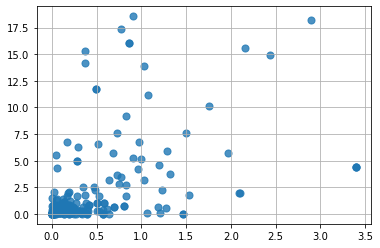

IMERG : le fichier a déjà été téléchargé pour la date 2017-05-12 11:58:13+00:00
valeur nulle rencontrée : gt = nan ; pixel = 1.534999966621399
IMERG : le fichier a déjà été téléchargé pour la date 2017-05-29 13:15:14+00:00
valeur nulle rencontrée : gt = nan ; pixel = 6.609999656677246
IMERG : le fichier a déjà été téléchargé pour la date 2017-06-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.12999999523162842
IMERG : le fichier a déjà été téléchargé pour la date 2017-06-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.13499999046325684
IMERG : le fichier a déjà été téléchargé pour la date 2017-05-14 05:44:20+00:00
valeur nulle rencontrée : gt = nan ; pixel = 1.2000000476837158
IMERG : le fichier a déjà été téléchargé pour la date 2017-06-01 06:42:08+00:00
valeur nulle rencontrée : gt = nan ; pixel = 7.804999828338623
IMERG : le fichier a déjà été téléchargé pour la date 2017-05-11 09:08:28+00:00
valeur nulle rencontrée : gt = nan ; pixel = 2.9600000381

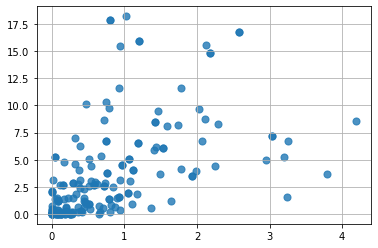

IMERG : le fichier a déjà été téléchargé pour la date 2017-08-12 11:58:13+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2017-08-29 13:15:14+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.429999977350235
IMERG : le fichier a déjà été téléchargé pour la date 2017-09-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-09-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-08-14 05:44:20+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2017-09-01 06:42:08+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2017-08-11 09:08:28+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.4599999785423279
IMERG : le fichier a déjà été téléchargé pour la date 2017-08-16 00:20:48+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été télécha

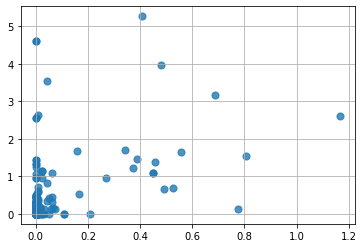

IMERG : le fichier a déjà été téléchargé pour la date 2017-12-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-12-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-12-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-12-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-12-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-28 01:30:02+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2017-12-22 00:32:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-09 20:35:42+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-01-06 21:40:21+00:00
IMERG : le fichier a déjà été téléchargé

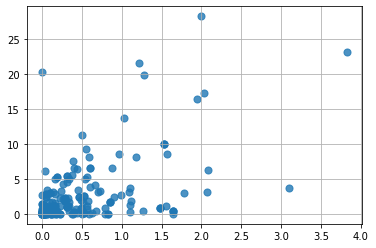

IMERG : le fichier a déjà été téléchargé pour la date 2018-05-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-05-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-06-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-06-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-05-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-06-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-05-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-05-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-06-28 01:30:02+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-05-22 00:32:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-06-09 20:35:42+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.06499999761581421
IMERG : le fichier a déjà été téléchargé pour la date 2

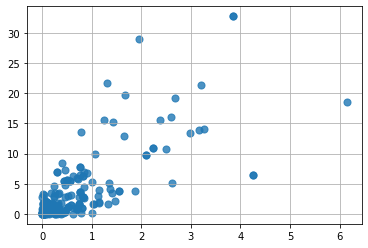

IMERG : le fichier a déjà été téléchargé pour la date 2018-08-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-08-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-08-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-08-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-08-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-28 01:30:02+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-08-22 00:32:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-09 20:35:42+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-09-06 21:40:21+00:00
IMERG : le fichier a déjà été téléchargé

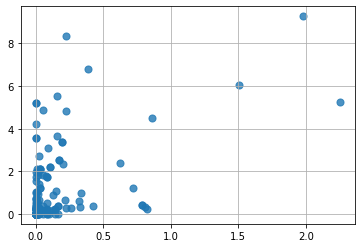

IMERG : le fichier a déjà été téléchargé pour la date 2018-12-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-12-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-12-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-12-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-12-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-28 01:30:02+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2018-12-22 00:32:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-09 20:35:42+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-01-06 21:40:21+00:00
IMERG : le fichier a déjà été téléchargé

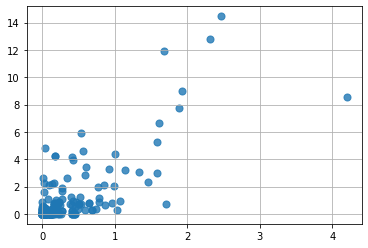

IMERG : le fichier a déjà été téléchargé pour la date 2019-05-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-05-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-06-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 3.554999828338623
valeur nulle rencontrée : gt = nan ; pixel = 1.3949999809265137
IMERG : le fichier a déjà été téléchargé pour la date 2019-06-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.6200000047683716
valeur nulle rencontrée : gt = nan ; pixel = 1.1099998950958252
IMERG : le fichier a déjà été téléchargé pour la date 2019-05-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-06-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-05-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-05-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-06-28 01:30:02+00:00
valeur nulle rencontrée :

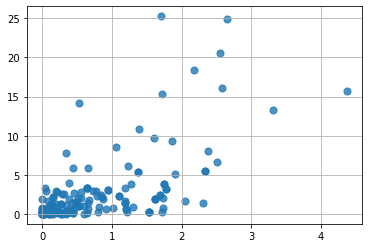

IMERG : le fichier a déjà été téléchargé pour la date 2019-08-12 11:58:13+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-08-29 13:15:14+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-14 14:33:31+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-13 16:43:18+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-08-14 05:44:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-01 06:42:08+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-08-11 09:08:28+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-08-16 00:20:48+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-28 01:30:02+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2019-08-22 00:32:20+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-09 20:35:42+00:00
IMERG : le fichier a déjà été téléchargé pour la date 2019-09-06 21:40:

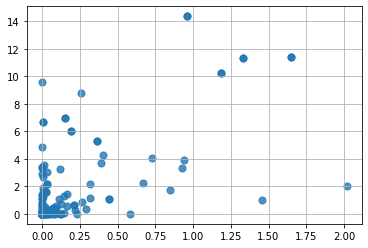

IMERG : le fichier a déjà été téléchargé pour la date 2019-12-12 11:58:13+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.1599999964237213
IMERG : le fichier a déjà été téléchargé pour la date 2019-12-29 13:15:14+00:00
valeur nulle rencontrée : gt = nan ; pixel = 1.2649999856948853
IMERG : le fichier a déjà été téléchargé pour la date 2020-01-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 5.244999885559082
IMERG : le fichier a déjà été téléchargé pour la date 2020-01-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.5699999928474426
IMERG : le fichier a déjà été téléchargé pour la date 2019-12-14 05:44:20+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.6449999809265137
IMERG : le fichier a déjà été téléchargé pour la date 2020-01-01 06:42:08+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2019-12-11 09:08:28+00:00
valeur nulle rencontrée : gt = nan ; pixel = 2.9599997997283936
IMERG : 

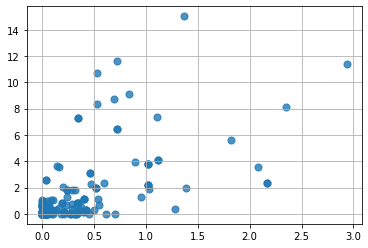

IMERG : le fichier a déjà été téléchargé pour la date 2020-05-12 11:58:13+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.8149999380111694
IMERG : le fichier a déjà été téléchargé pour la date 2020-05-29 13:15:14+00:00
valeur nulle rencontrée : gt = nan ; pixel = 1.149999976158142
valeur nulle rencontrée : gt = nan ; pixel = 0.8549998998641968
IMERG : le fichier a déjà été téléchargé pour la date 2020-06-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 6.650000095367432
valeur nulle rencontrée : gt = nan ; pixel = 0.4099999666213989
IMERG : le fichier a déjà été téléchargé pour la date 2020-06-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 5.564999580383301
IMERG : le fichier a déjà été téléchargé pour la date 2020-05-14 05:44:20+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.2900000214576721
IMERG : le fichier a déjà été téléchargé pour la date 2020-06-01 06:42:08+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
valeur nulle rencontrée : 

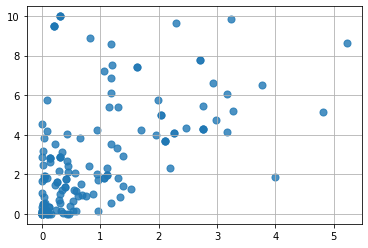

IMERG : le fichier a déjà été téléchargé pour la date 2020-08-12 11:58:13+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.13499999046325684
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2020-08-29 13:15:14+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.125
valeur nulle rencontrée : gt = nan ; pixel = 0.19499999284744263
IMERG : le fichier a déjà été téléchargé pour la date 2020-09-14 14:33:31+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.5049999952316284
valeur nulle rencontrée : gt = nan ; pixel = 0.0
IMERG : le fichier a déjà été téléchargé pour la date 2020-09-13 16:43:18+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.0
valeur nulle rencontrée : gt = nan ; pixel = 0.14499999582767487
IMERG : le fichier a déjà été téléchargé pour la date 2020-08-14 05:44:20+00:00
valeur nulle rencontrée : gt = nan ; pixel = 0.25
valeur nulle rencontrée : gt = nan ; pixel = 0.699999988079071
IMERG : le fichier a déjà été 

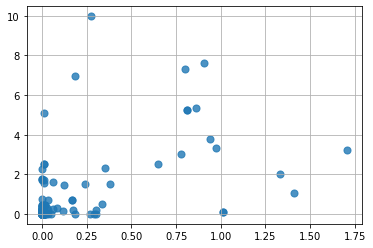

In [11]:
for year in [2017,2018,2019,2020]:
    periods = {
        f"dec-jan_{year}" : {  "start" : datetime(year-1,12,1,tzinfo=timezone.utc),
                                "end"  : datetime(year,1,31,tzinfo=timezone.utc)
                            },
        f"may-jun_{year}" : {  "start" : datetime(year,5,1,tzinfo=timezone.utc),
                                "end"  : datetime(year,6,30,tzinfo=timezone.utc)
                            },
        f"oct_nov_{year}" : {  "start" : datetime(year,8,1,tzinfo=timezone.utc),
                                "end"  : datetime(year,9,30,tzinfo=timezone.utc)
                            }
        }

    result_df = main(periods)
    result_df.to_csv(eval_dir + rf"/result_{year}.csv")
    


In [ ]:
periods = {
    "2017" :           {    "start" : datetime(2017,1,1,tzinfo=timezone.utc),
                            "end"  : datetime(2017,12,31,tzinfo=timezone.utc)
                        },
    "2018" :           {    "start" : datetime(2018,1,1,tzinfo=timezone.utc),
                            "end"  : datetime(2018,12,31,tzinfo=timezone.utc)
                        },
    "2019" :           {    "start" : datetime(2019,1,1,tzinfo=timezone.utc),
                            "end"  : datetime(2019,12,31,tzinfo=timezone.utc)
                        },
    "2020" :           {    "start" : datetime(2020,1,1,tzinfo=timezone.utc),
                            "end"  : datetime(2020,12,31,tzinfo=timezone.utc)
                        }
    }
